In [1]:
from alphatoe import models, interpretability, data
from showmethetypes import SMTT
import torch
from torch import Tensor
import einops

In [2]:
tt = SMTT()

In [3]:
"""
Don't really remember how any of this works, but I need to:
1. Load the model
2. Load the SAE
3. Be able to run the model using the SAE (and not normal MLP activations)
4. Get the loss on training examples
5. Run the model w/ loss on all examples
"""

"\nDon't really remember how any of this works, but I need to:\n1. Load the model\n2. Load the SAE\n3. Be able to run the model using the SAE (and not normal MLP activations)\n4. Get the loss on training examples\n5. Run the model w/ loss on all examples\n"

In [4]:
autoenc = models.SparseAutoEncoder(512, 512).cuda()
autoenc.load_state_dict(
    torch.load("./512_sparse_autoencoder_on_activations_20NOV2023_parameters.pt")
)

<All keys matched successfully>

In [5]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [6]:
def substitute_MLP_acts(
    autoenc,
    model,
    seq: Tensor,
) -> Tensor:
    def hook(module, input, output):
        # result = output.clone()
        _, _, out = autoenc(output)
        return out

    try:
        with torch.no_grad():
            handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
            logits = model(seq)
            handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits

In [7]:
res = data.gen_data("prob all", 1.0)

Generating all possible games...
Generating all games...
Finished generating all games
Generated 255168 games
Generated array of moves


100%|██████████| 255168/255168 [00:27<00:00, 9330.28it/s] 


torch.Size([255168, 10, 10])
Generated all data and probabilistic labels


In [8]:
tt(res)

tuple
    ├── Tensor (dtype: torch.int64)
    │   │   (device: cpu)
    │   ├── dim_0 (255168)
    │   └── dim_1 (10)
    ├── Tensor (dtype: torch.float32)
    │   │   (device: cpu)
    │   ├── dim_0 (255168)
    │   ├── dim_1 (10)
    │   └── dim_2 (10)
    ├── Tensor (dtype: torch.int64)
    │   │   (device: cpu)
    │   ├── dim_0 (0)
    │   └── dim_1 (10)
    └── Tensor (dtype: torch.float32)
        │   (device: cpu)
        ├── dim_0 (0)
        ├── dim_1 (10)
        └── dim_2 (10)


In [9]:
data, labels = res[0].to("cuda"), res[1].to("cuda")

In [10]:
model(data[:100])

tensor([[[  16.4406,   16.4415,   16.4427,  ...,   16.4371,   16.4422,
          -117.7469],
         [   9.6051,    9.6054,    9.6079,  ...,    9.6036,    9.6086,
           -24.5334],
         [  16.2068,   16.2037,   16.2065,  ...,   16.2034,   16.2090,
           -40.7391],
         ...,
         [  17.0553,    7.5923,  -14.4237,  ...,    8.2257,  -13.7136,
            -2.4222],
         [ -20.7949,  -15.5048,    7.3724,  ...,  -13.1251,    6.9404,
             7.6090],
         [ -14.4291,   -8.8661,  -12.8354,  ...,   -4.4761,   -9.0325,
            59.2667]],

        [[  16.4406,   16.4415,   16.4427,  ...,   16.4371,   16.4422,
          -117.7469],
         [  15.6755,   15.6813,   15.6822,  ...,   15.6765,   15.6811,
           -55.3074],
         [  19.2528,   19.2595,   19.2649,  ...,  -43.4179,   19.2645,
           -68.2348],
         ...,
         [   7.9144,  -17.3069,    7.5984,  ...,    7.9098,   16.9866,
            -5.8234],
         [ -23.7590,    6.5395,  -16.480

In [11]:
loss_fn = torch.nn.functional.cross_entropy


def rearrange(t: Tensor):
    """Formatting tensors to play nicely with F.cross_entropy.

    This can also be achieved by permuting the last two dimensions, but this should be faster.
    """
    return einops.rearrange(t, "batch seq token -> (batch seq) token")

In [12]:
logits = model(data[:100])
loss = loss_fn(rearrange(logits), rearrange(labels[:100]))

In [13]:
loss

tensor(1.2640, device='cuda:0', grad_fn=<DivBackward1>)

In [14]:
logits = substitute_MLP_acts(autoenc, model, data[:100])
loss = loss_fn(rearrange(logits), rearrange(labels[:100]))

In [15]:
tt(data)

Tensor (dtype: torch.int64)
    │   (device: cuda:0)
    ├── dim_0 (255168)
    └── dim_1 (10)


In [22]:
batch_size = 100

normal_losses = []
sae_losses = []
with torch.inference_mode():
    for batch in range(0, data.shape[0], batch_size):
        input_batch = data[batch : batch + batch_size]
        label_batch = labels[batch : batch + batch_size]
        logits = model(input_batch)
        tt(logits)
        normal_losses.append(
            loss_fn(rearrange(logits), rearrange(label_batch), reduction="none")
        )
        tt(normal_losses)
        sae_logits = substitute_MLP_acts(autoenc, model, input_batch)
        sae_losses.append(
            loss_fn(rearrange(sae_logits), rearrange(label_batch), reduction="none")
        )

Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (100)
    ├── dim_1 (10)
    └── dim_2 (10)
list (1)
    └── Tensor (dtype: torch.float32)
        │   (device: cuda:0)
        └── dim_0 (1000)
Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (100)
    ├── dim_1 (10)
    └── dim_2 (10)
list (2)
    └── Tensor (dtype: torch.float32)
        │   (device: cuda:0)
        └── dim_0 (1000)
Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (100)
    ├── dim_1 (10)
    └── dim_2 (10)
list (3)
    └── Tensor (dtype: torch.float32)
        │   (device: cuda:0)
        └── dim_0 (1000)
Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (100)
    ├── dim_1 (10)
    └── dim_2 (10)
list (4)
    └── Tensor (dtype: torch.float32)
        │   (device: cuda:0)
        └── dim_0 (1000)
Tensor (dtype: torch.float32)
    │   (device: cuda:0)
    ├── dim_0 (100)
    ├── dim_1 (10)
    └── dim_2 (10)
list (5)
    └── Tensor (dtype:

In [23]:
torch.cuda.empty_cache()

In [30]:
normal_results = torch.concat(normal_losses).cpu()
sae_results = torch.concat(sae_losses).cpu()

In [32]:
tt(normal_results)
tt(sae_results)

Tensor (dtype: torch.float32)
    │   (device: cpu)
    └── dim_0 (2551680)
Tensor (dtype: torch.float32)
    │   (device: cpu)
    └── dim_0 (2551680)


In [27]:
sae_results

tensor([2.7692, 2.7367, 2.6175,  ..., 6.2255, -0.0000, -0.0000],
       device='cuda:0')

In [36]:
import matplotlib.pyplot as plt
import numpy as np

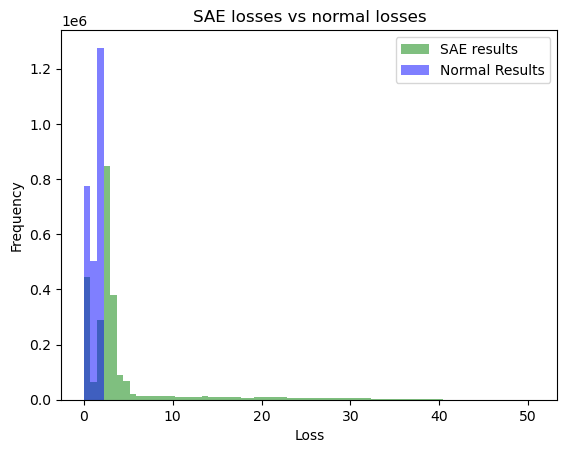

In [40]:
# Plot histograms
bin_edges = np.linspace(
    min(min(normal_results), min(sae_results)),
    max(max(normal_results), max(sae_results)),
    num=70,
)


plt.hist(sae_results, bins=bin_edges, alpha=0.5, label="SAE results", color="green")
plt.hist(
    normal_results, bins=bin_edges, alpha=0.5, label="Normal Results", color="blue"
)

# Adding labels and title
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.title("SAE losses vs normal losses")
plt.legend()

# Show plot
plt.show()